In [42]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [43]:
import numpy as np
import pandas as pd

In [44]:
import datetime as dt
from datetime import timedelta

In [45]:
import sys, inspect

# Reflect Tables into SQLAlchemy ORM

In [46]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [47]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [48]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [49]:
# We can view all of the classes that automap found
for classes_found in Base.classes:
    print (classes_found)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [50]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [51]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(bind=engine)

# Exploratory Climate Analysis

In [52]:
measurement_df = pd.read_sql("SELECT * FROM measurement", engine)
measurement_df.dropna(how='any', inplace=True)
measurement_df['date'].max()

'2017-08-23'

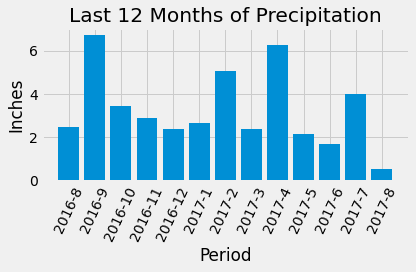

In [53]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
measurement_df = pd.read_sql("SELECT * FROM measurement", engine)

measurement_df.dropna(how='any', inplace=True)

measurement_df['year'] = pd.DatetimeIndex(measurement_df['date']).year.astype(str)
measurement_df['month'] = pd.DatetimeIndex(measurement_df['date']).month.astype(str)
measurement_df['yr_mth'] = measurement_df['year'] + "-" + measurement_df['month']

measure_p12mth = measurement_df.loc[measurement_df['date'] >= '2016-08-23']

measure_p12mth = measurement_df.loc[measurement_df['date'] >= '2016-08-23'].sort_values(by='id')
measure_p12mth.groupby(by=['yr_mth'], sort=False).sum()

plt.bar(measure_p12mth['yr_mth'],measure_p12mth['prcp'])
plt.xticks(rotation=65)

plt.title('Last 12 Months of Precipitation')
plt.xlabel('Period')
plt.ylabel('Inches')

plt.tight_layout()
plt.savefig("Images/Last_12_Month_of_Precipitation.png")
plt.show()

In [54]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
climate_measure = engine.execute("SELECT * FROM measurement")

climate_table =[]

climate_measure_headers = climate_measure.keys()

for cl in climate_measure:
    if cl[2] >= '2016-08-23':
        climate_table.append(
            {
                'date': cl[2],
                'prcp': cl[3]
            }
        )

# Save the query results as a Pandas DataFrame and set the index to the date column
climate_table_df = pd.DataFrame(climate_table)
climate_table_df.set_index('date', inplace = True)
climate_table_df.dropna(how='any', inplace = True)

# Sort the dataframe by date
climate_table_df.sort_index(inplace=True)
climate_table_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


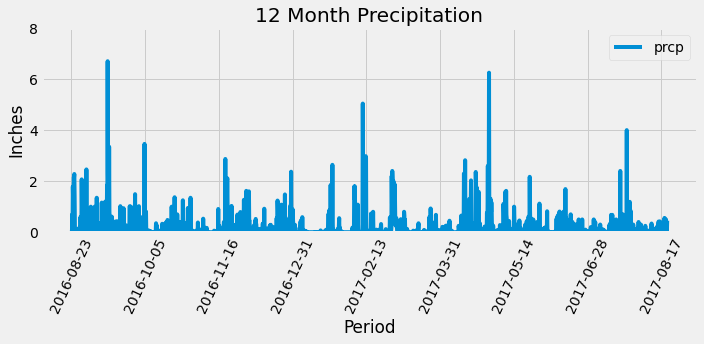

In [55]:
# climate_table_df.plot(kind="bar", figsize=(20,3))
climate_table_df.plot(figsize=(10,5),ylim=(0,8))
plt.xticks(rotation=65)
plt.title('12 Month Precipitation')
plt.xlabel('Period')
plt.ylabel('Inches')

plt.tight_layout()
plt.savefig("Images/12_Month_Precipitation.png")
plt.show()

In [56]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measure_p12mth_st = measure_p12mth[['station','prcp']]
measure_12mth_stat = measure_p12mth_st.rename(columns={'prcp': 'Precipitation'})
measure_12mth_stat.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [57]:
# Design a query to show how many stations are available in this dataset?
no_stations = pd.Series(measurement_df['station'].unique())
no_stations

0    USC00519397
1    USC00513117
2    USC00514830
3    USC00517948
4    USC00518838
5    USC00519523
6    USC00519281
7    USC00511918
8    USC00516128
dtype: object

In [58]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = pd.Series(measurement_df['station'].value_counts())
active_stations

USC00519281    2772
USC00513117    2696
USC00519397    2685
USC00519523    2572
USC00516128    2484
USC00514830    1937
USC00511918    1932
USC00517948     683
USC00518838     342
Name: station, dtype: int64

In [59]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
#Summary Status

station_low = []
most_active = active_stations.head(1).index.item()

for s in no_stations:
    station_ltemp = measure_p12mth.loc[measure_p12mth['station'] == s]
    stat_low = {
        'Station': s,
        'Lowest Temp' : station_ltemp['tobs'].min(),
        'Highest Temp' : station_ltemp['tobs'].max(),
        'Average Temp' : station_ltemp['tobs'].mean(),
        'Observations' :  station_ltemp['tobs'].count()
    }
    station_low.append(stat_low)
station_low_df = pd.DataFrame(station_low)
station_low_df.fillna(value=0, inplace=True)
station_low_df.set_index('Station', inplace=True)
station_low_df.sort_values('Observations', ascending=False)
print("Most Active Station:")
station_low_df.loc[[most_active]]

Most Active Station:


,Lowest Temp,Highest Temp,Average Temp,Observations
Station,,,,
USC00519281,59.0,83.0,73.107955,352


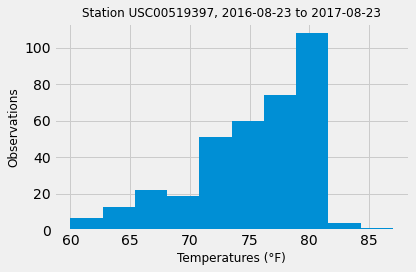

In [60]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_act_station = measure_p12mth.loc[measure_p12mth['station'] == 'USC00519397']
most_act_station.hist('tobs')
plt.title('Station USC00519397, 2016-08-23 to 2017-08-23', fontsize='12')
plt.xlabel('Temperatures (°F)', fontsize='12')
plt.ylabel('Observations', fontsize='12')

plt.tight_layout()
plt.savefig("Images/Station_USC00519397.png")
plt.show()

## Bonus Challenge Assignment

In [61]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


In [62]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

trip_temps = calc_temps('2016-02-28', '2016-03-05') 
print(trip_temps)

[(62.0, 69.88636363636364, 80.0)]


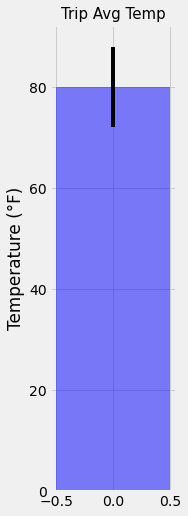

In [63]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = trip_temps[0][0]
tmax = trip_temps[0][1]
tavg = trip_temps[0][2]

y_err = tmax-tmin

plt.figure(figsize=(2,8))
plt.bar(0, tavg, yerr=y_err, align="center", width=1, color="b", alpha=0.5)
plt.ylim=(0,50)
plt.ylabel('Temperature (°F)')
plt.title('Trip Avg Temp', fontsize=15)
plt.savefig("Images/Avg_Trip_Temperature.png")
plt.show()

In [64]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-02-28'
end_date = '2017-03-05'

selection = [station.station, station.name, station.latitude, 
       station.longitude, station.elevation, func.sum(measurement.prcp)]

travel_precp = session.query(*selection).\
    filter(measurement.station == station.station).\
    filter(measurement.date >= start_date).\
    filter(measurement.date <= end_date).\
    group_by(station.name).order_by(func.sum(measurement.prcp).desc()).all()

for st, nam, lat, lng, elv, prcp in travel_precp:
    print(st, nam, lat, lng, elv, round(prcp,2))

USC00519281 WAIHEE 837.5, HI US 21.45167 -157.84888999999998 32.9 4.72
USC00513117 KANEOHE 838.1, HI US 21.4234 -157.8015 14.6 4.45
USC00516128 MANOA LYON ARBO 785.2, HI US 21.3331 -157.8025 152.4 4.07
USC00517948 PEARL CITY, HI US 21.3934 -157.9751 11.9 2.98
USC00519397 WAIKIKI 717.2, HI US 21.2716 -157.8168 3.0 2.74
USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US 21.33556 -157.71139 19.5 2.32
USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US 21.5213 -157.8374 7.0 1.16


In [65]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [66]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
cal_normal = []
normals = []

# Set the start and end date of the trip
start_date = '2017-02-28'
end_date = '2017-03-05'

# Use the start and end date to create a range of dates
date_range = pd.date_range(start=start_date, end=end_date)

# Stip off the year and save a list of %m-%d strings
mth_day_lst = date_range.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in mth_day_lst:
    cal_normal.append(daily_normals(date))

# Flatten The List
for day in cal_normal:
    for cal in day:
        normals.append(cal)
    
normals

[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [67]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_norms_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
daily_norms_df['date'] = date_range
daily_norms_df.set_index(['date'], inplace=True)
daily_norms_df.head()

,tmin,tavg,tmax
date,,,
2017-02-28,65.0,70.655172,80.0
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0


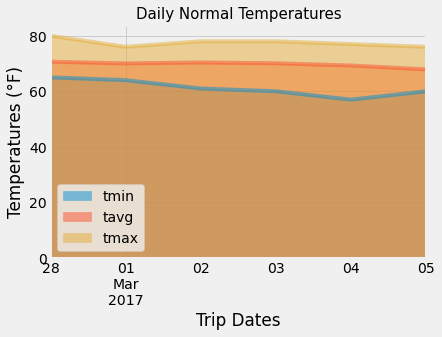

In [68]:
# Plot the daily normals as an area plot with `stacked=False`
daily_norms_df.plot(kind='area', stacked=False)
plt.title('Daily Normal Temperatures', fontsize=15)
plt.ylabel('Temperatures (°F)')
plt.xlabel('Trip Dates')
plt.savefig("Images/Daily_Normals.png")
plt.show()